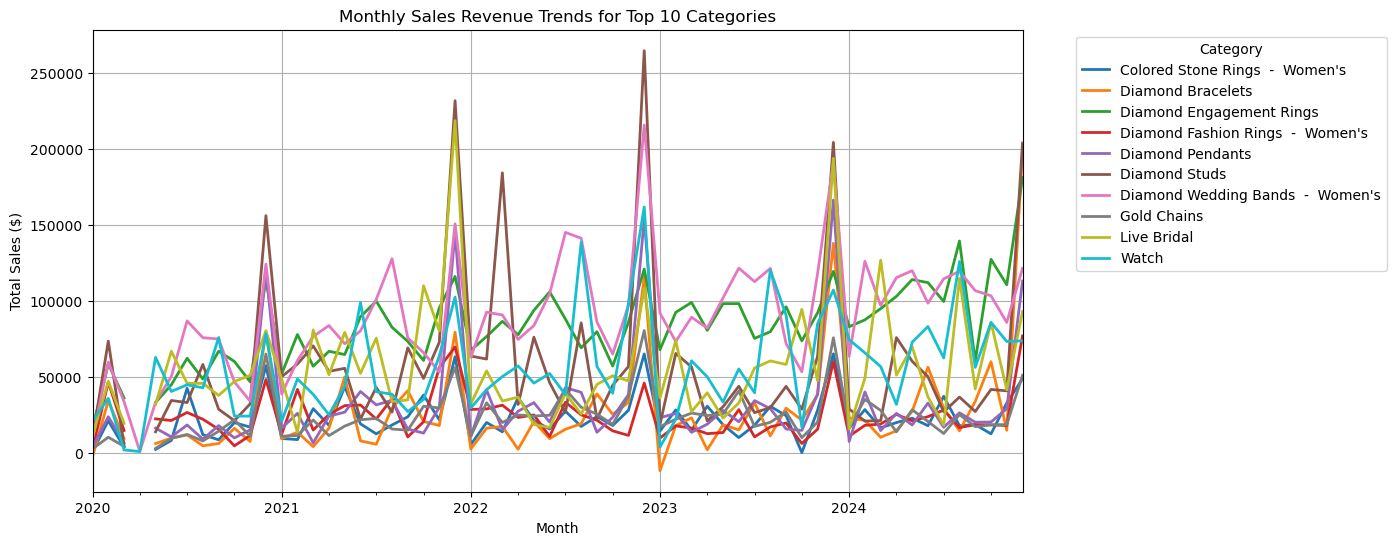

In [5]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np


# Initialize BigQuery client
client = bigquery.Client()

# Define the query to get monthly sales revenue for the top 10 categories
query = """
WITH top_categories AS (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
)
SELECT 
    DATE_TRUNC(sold_date, MONTH) AS month,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

# Run the query
df = client.query(query).to_dataframe()

# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Pivot for visualization
df_pivot = df.pivot(index="month", columns="category_name", values="total_sales")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Sales Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()


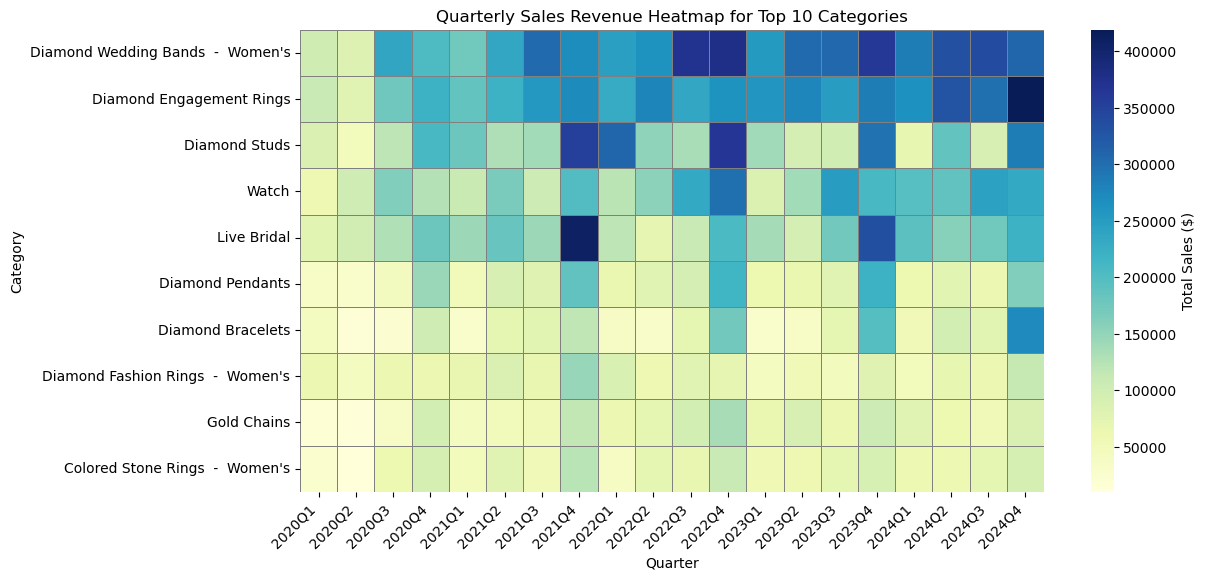

In [6]:
# Convert 'month' column to datetime if not already
df['month'] = pd.to_datetime(df['month'])

# Aggregate to quarterly data
df['quarter'] = df['month'].dt.to_period('Q')
df_quarterly = df.groupby(['quarter', 'category_name'])['total_sales'].sum().reset_index()

# Determine total sales per category for sorting
category_sales_rank = df_quarterly.groupby('category_name')['total_sales'].sum().sort_values(ascending=False).index

# Pivot for heatmap (sorted categories)
df_heatmap = df_quarterly.pivot(index="category_name", columns="quarter", values="total_sales")
df_heatmap = df_heatmap.loc[category_sales_rank]  # Sort categories by total sales

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(df_heatmap, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Total Sales ($)'})

# Formatting
plt.title("Quarterly Sales Revenue Heatmap for Top 10 Categories")
plt.xlabel("Quarter")
plt.ylabel("Category")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()



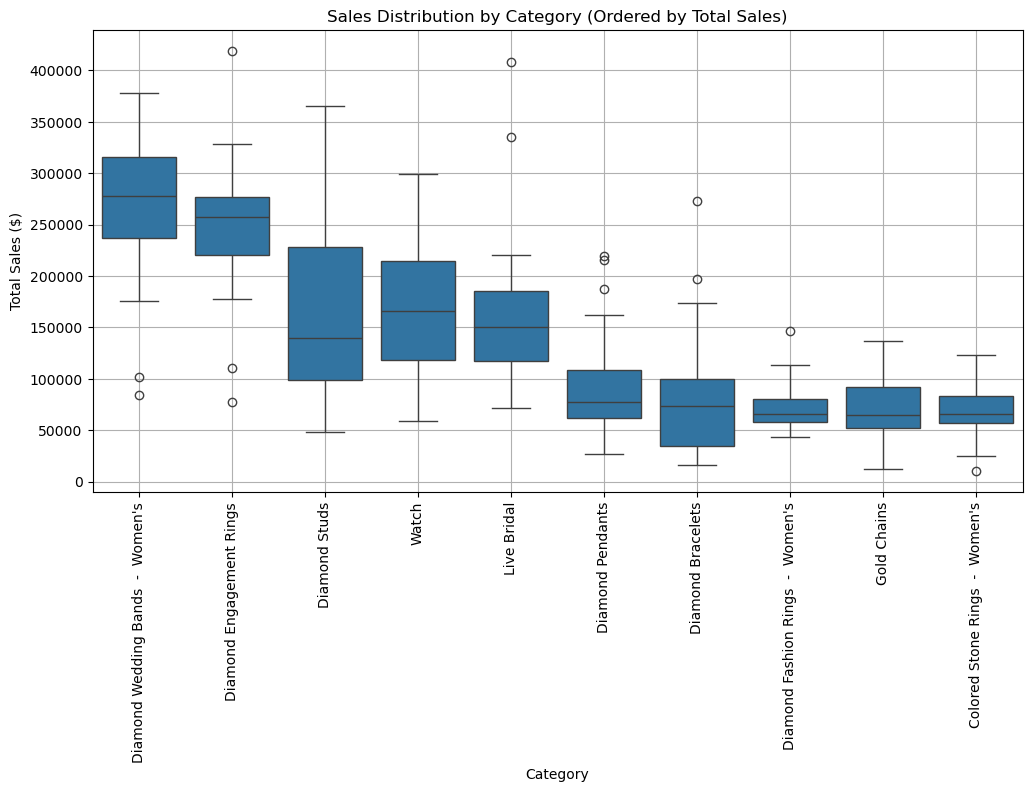

Identified Outliers (Z-score > 3 or < -3):
   quarter                      category_name  total_sales   z_score
73  2021Q4  Diamond Fashion Rings  -  Women's    146005.35  3.044082


In [10]:
# Compute total sales per category for sorting
category_sales_rank = df_quarterly.groupby("category_name")["total_sales"].sum().sort_values(ascending=False).index

# Set category order based on total sales
plt.figure(figsize=(12, 6))
sns.boxplot(x="category_name", y="total_sales", data=df_quarterly, order=category_sales_rank)

# Formatting
plt.xticks(rotation=90)
plt.title("Sales Distribution by Category (Ordered by Total Sales)")
plt.xlabel("Category")
plt.ylabel("Total Sales ($)")
plt.grid(True)

# Show plot
plt.show()

# Display outliers
print("Identified Outliers (Z-score > 3 or < -3):")
print(df_outliers[["quarter", "category_name", "total_sales", "z_score"]])


## Identifying Key Trends:
### Top-Selling Categories:
Women's Diamond Wedding Bands and Diamond Engagement Rings have the highest median sales and significant variability. These categories are contributing the most to overall revenue.

### Mid-Range Performers:
Diamond Studs, Watches, Live Bridal, and Diamond Pendants also have high median sales, but with more spread (variation) between quarters.

### Lower-Selling Categories:
Gold Chains, Women's Diamond Fashion Rings and Women's Colored Stone Rings have the lowest median sales, meaning they contribute less to total revenue of the top 10 categories.

## Understanding Oultiers & Variability:
### Large Spreads (High Variability in Sales)
- Diamond Studs, Watches, and Live Bridal show larger interquartile ranges (IQRs), indicating fluctuating demand between quarters.
- These categories may be harder to forecast because their sales are less consistent.
### Frequent Outliers (Spikes in Sales)
- Outliers (points above the whiskers) suggest quarters where sales surged unexpectedly.
- Women's Diamond Wedding Bands, Diamond Engagement Rings and Watches show several high ouliers, like due to seasonal spikes, e.g. holiday shopping in Q4.
### Consisten Performers (Lower Variability)
- Gold Chains and Women's Colored Stone Rings have smaller IQRs, meaning their sales are more stable over time.
- these categories are likely easier to forecast,

### Interpreting the Identified Outlier:
The Z-score analysis flagged Q4 2021 for "Diamond Fashion Rings - Women's" as a statistical outlier.

## What does this mean? 
- Q4 2021 (October-December '21)
- Category: Women's Diamond Fashion Rings
- Total Sales: $146,005.35
- Z-score: 3.04 - This means the sales in this quarter were more than 3 standard deviations above the mean for this category.

## Why is this an outlier?
- A Z-score above 3 indicates that this sales value is significantly higher than the typical sales for this cateory.
- This suggests a spike in demand that is not consistent with previous quarters.

## Possible reasons for the spike?
- Historically strong quarter for jewelry sales due to the holidays (Black Friday, Christmas, engagement season).
- Economic Factors - did consumer spending on luxury items increase in late 2021?
- One-off Large Purchases? A few high-value transactions could have pushed up sales.

## Impact on Forecasting:
- Adjust for Seasonality: If this spike is seasonal, the model should incorporate seasonality.
- Handle Anomalies Carefully: If this was a one-time event, using raw historial data could lead to overestimated forecasts.
- Compare to Other Q4s: Checking sales for Q4 in other years will help determine if htis is a recurring trend or a true anomaly.

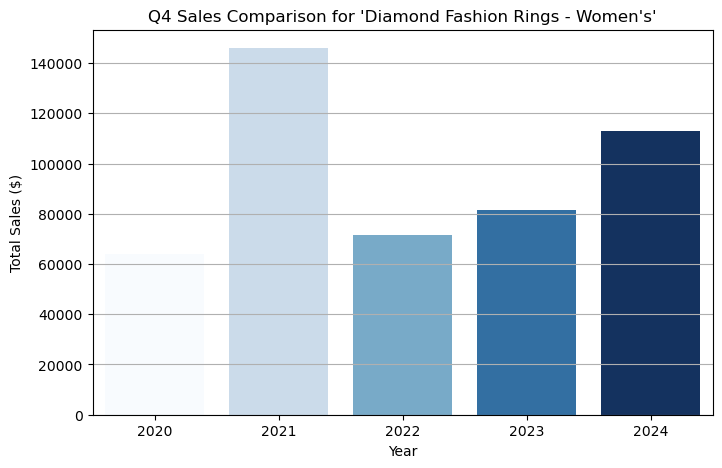

   year                      category_name  total_sales
0  2020  Diamond Fashion Rings  -  Women's     64099.11
1  2021  Diamond Fashion Rings  -  Women's    146005.35
2  2022  Diamond Fashion Rings  -  Women's     71621.20
3  2023  Diamond Fashion Rings  -  Women's     81537.60
4  2024  Diamond Fashion Rings  -  Women's    113159.47


In [19]:
query = """
SELECT 
    year,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE quarter LIKE 'Oct%'
AND category_name = "Diamond Fashion Rings  -  Women's"  -- Using double quotes
GROUP BY year, category_name
ORDER BY year;
"""

# Run the query
df_q4_comparison = client.query(query).to_dataframe()

# Plot Q4 sales comparison over years
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Q4 sales comparison over years
plt.figure(figsize=(8, 5))
sns.barplot(x="year", y="total_sales", hue="year", data=df_q4_comparison, palette="Blues", legend=False)

# Formatting
plt.title("Q4 Sales Comparison for 'Diamond Fashion Rings - Women's'")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y")

# Show plot
plt.show()

# Display the Q4 sales comparison data
print(df_q4_comparison)



## Key Takeaways
### Biggest Spike: Q4 2021 ($146,005.35)
- Q4 2021 stands out as an anomaly, with significantly higher sales compared to other years.
- This supports our earlier Z-score analysis that flagged it as an outlier.
### Post-2021 Dip & Recovery:
- Sales dropped sharply in 2022 ($71,621.20) after the 2021 spike.
- Sales recovered in 2023 ($81,537.60) and jumped again in 2024 ($113,159.47).

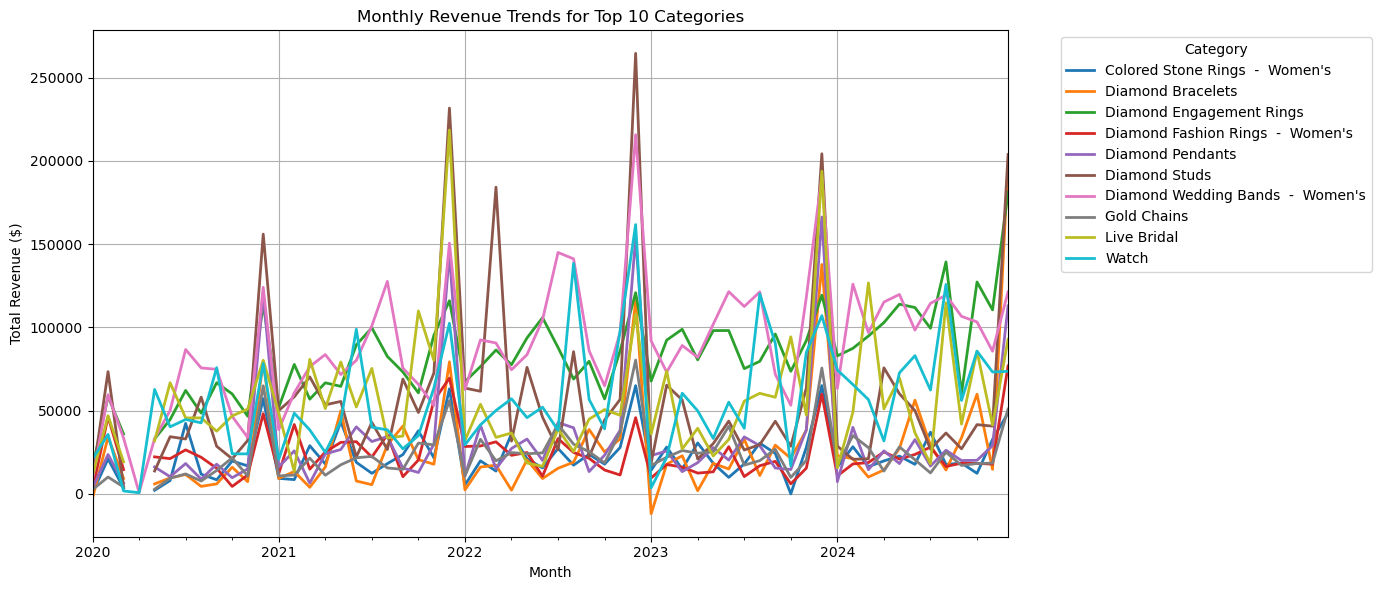

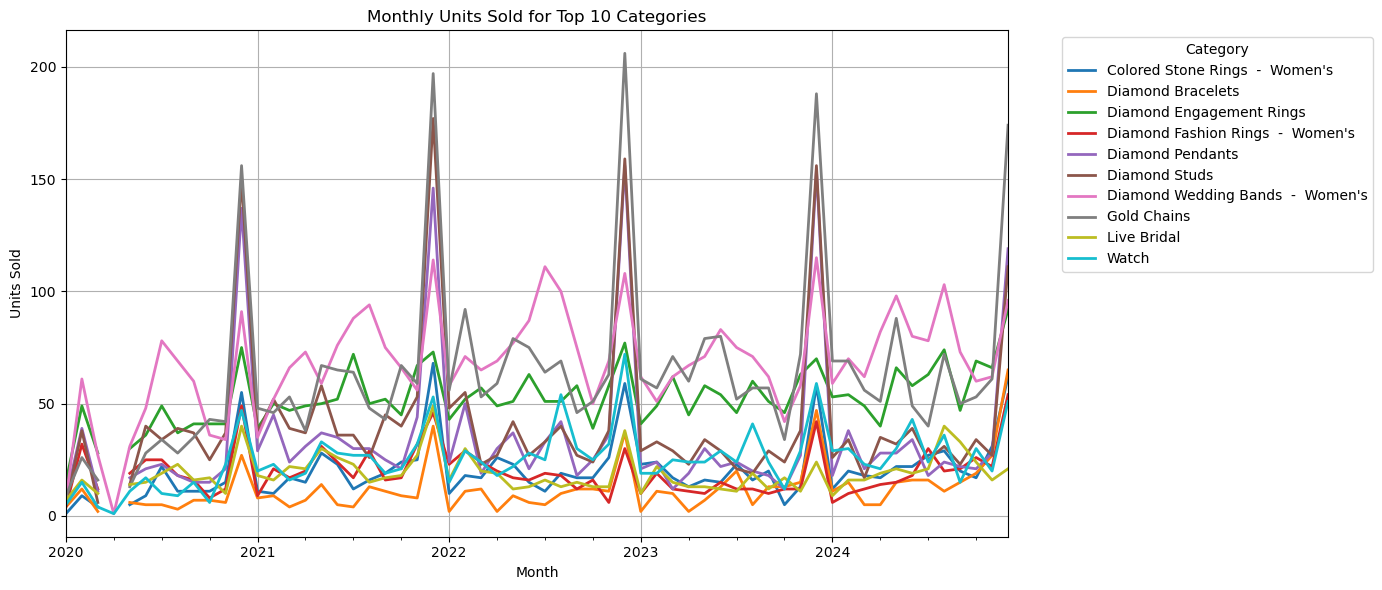

In [43]:
# Query definition
query = """
WITH top_categories AS (
  SELECT category_name
  FROM (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
  )
)

SELECT
  DATE_TRUNC(sold_date, MONTH) AS month,
  category_name,
  COUNT(DISTINCT sku) AS items_sold,
  ROUND(SUM(sale_total), 2) AS total_revenue
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
  AND category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

df = client.query(query).to_dataframe()

# Convert 'month' column to datetime
df['month'] = pd.to_datetime(df['month'])

# Create pivot tables for each metric
df_pivot_revenue = df.pivot(index='month', columns='category_name', values='total_revenue')
df_pivot_units = df.pivot(index='month', columns='category_name', values='items_sold')

# ---- Plot 1: Monthly Revenue Trends ----
plt.figure(figsize=(14, 6))
df_pivot_revenue.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot 2: Monthly Units Sold Trends ----
plt.figure(figsize=(14, 6))
df_pivot_units.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Units Sold for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

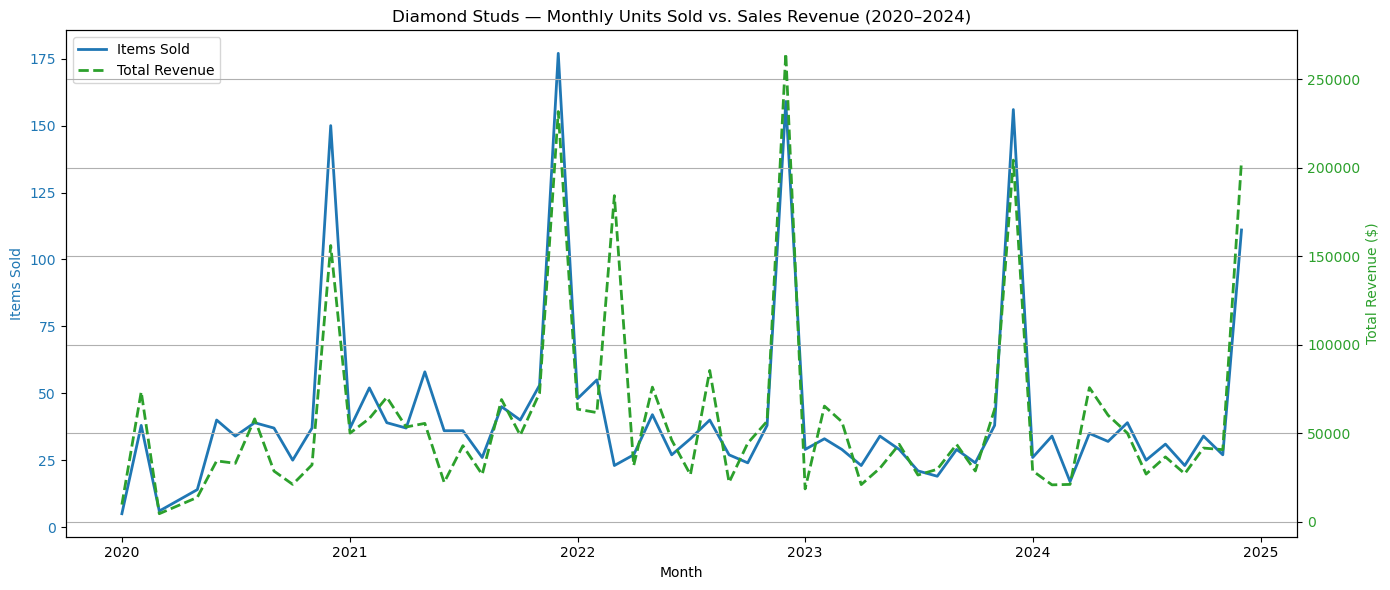

In [44]:
# Filter to just one category
category_name = "Diamond Studs"
df_filtered = df[df['category_name'] == category_name].copy()
df_filtered['month'] = pd.to_datetime(df_filtered['month'])

# Sort by month in case it's not sorted
df_filtered = df_filtered.sort_values('month')

# Set up dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot items sold (left y-axis)
color = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Items Sold", color=color)
ax1.plot(df_filtered['month'], df_filtered['items_sold'], color=color, label='Items Sold', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Create right y-axis for revenue
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Total Revenue ($)", color=color)
ax2.plot(df_filtered['month'], df_filtered['total_revenue'], color=color, linestyle='dashed', label='Total Revenue', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title(f"{category_name} — Monthly Units Sold vs. Sales Revenue (2020–2024)")
fig.tight_layout()

# Optional combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()

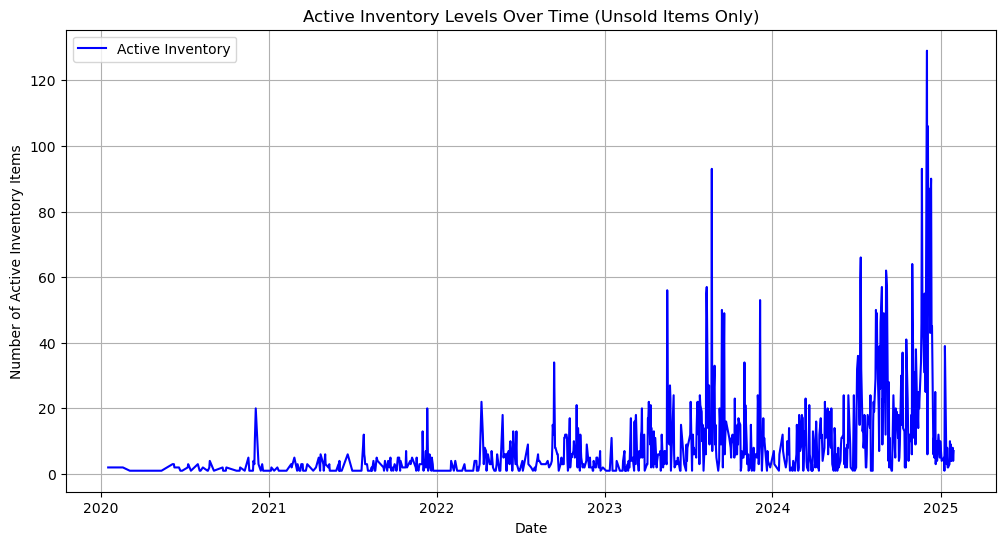

In [27]:
# Query to fetch active inventory over time (only unsold items)
query = """
SELECT 
    DATE(purchase_date) AS date,
    COUNT(sku) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE sold_status = 0  -- Only count inventory still in stock
AND purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query
df_active_inventory = client.query(query).to_dataframe()

# Convert 'date' to datetime format
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Plot the active inventory levels over time
plt.figure(figsize=(12, 6))
plt.plot(df_active_inventory['date'], df_active_inventory['active_inventory_count'], color='b', label="Active Inventory")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Number of Active Inventory Items")
plt.title("Active Inventory Levels Over Time (Unsold Items Only)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

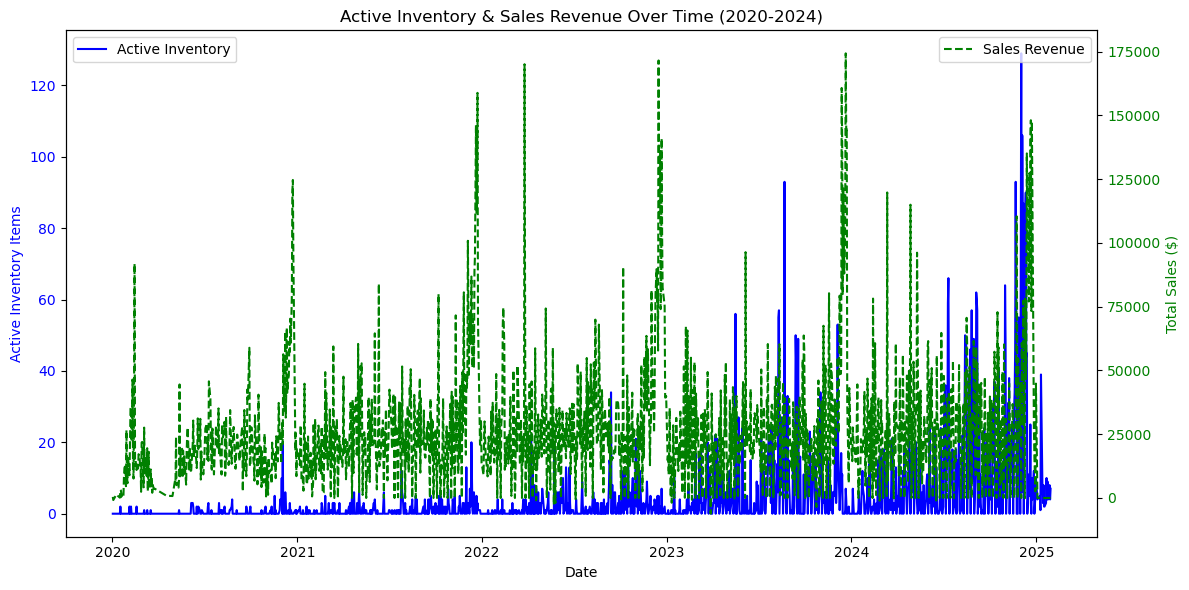

In [28]:
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()

# Convert 'date' to datetime format
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# Plot the active inventory levels and sales trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['active_inventory_count'], color="b", label="Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Title and legend
plt.title("Active Inventory & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()


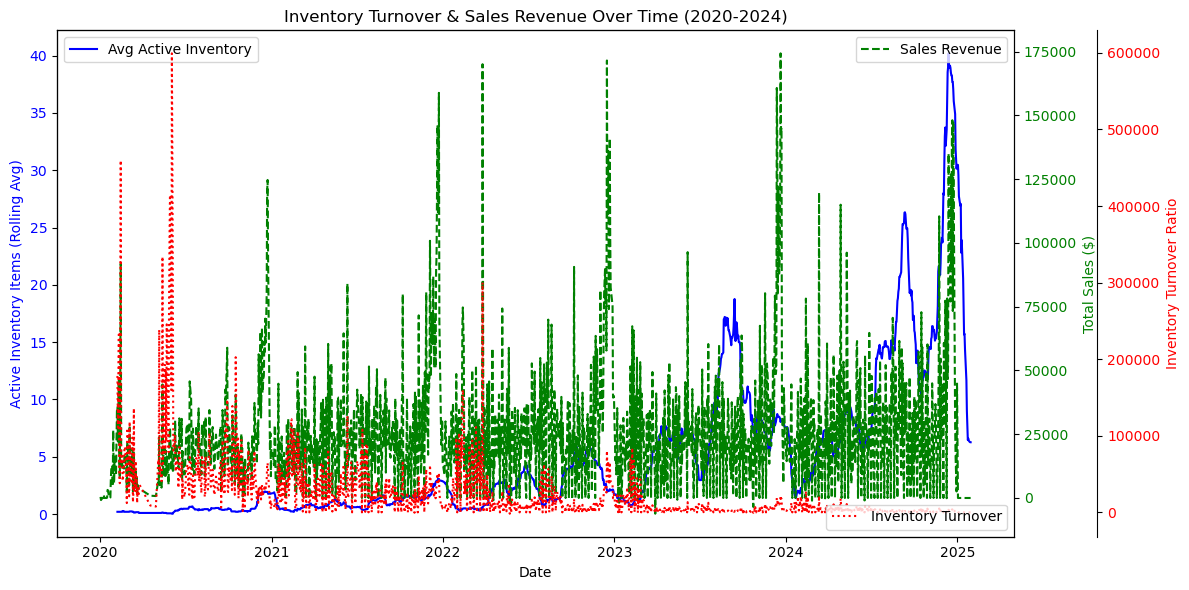

In [30]:
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Query to fetch cumulative active inventory levels over time
query_inventory = """
SELECT 
    DATE(purchase_date) AS date,
    SUM(CASE WHEN sold_status = 0 THEN 1 ELSE 0 END) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for active inventory
df_active_inventory = client.query(query_inventory).to_dataframe()
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# **Compute a Rolling 30-Day Average for Active Inventory**
df_inventory_sales['avg_active_inventory'] = df_inventory_sales['active_inventory_count'].rolling(window=30).mean()

# **Calculate Inventory Turnover Ratio**
df_inventory_sales['inventory_turnover'] = df_inventory_sales['total_sales'] / df_inventory_sales['avg_active_inventory']

# Plot the active inventory levels, sales trends, and inventory turnover
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items (Rolling Avg)", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['avg_active_inventory'], color="b", label="Avg Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Plot Inventory Turnover (Dashed Line)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third y-axis
ax3.set_ylabel("Inventory Turnover Ratio", color="r")
ax3.plot(df_inventory_sales['date'], df_inventory_sales['inventory_turnover'], color="r", linestyle="dotted", label="Inventory Turnover")
ax3.tick_params(axis="y", labelcolor="r")

# Title and legend
plt.title("Inventory Turnover & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# Show the plot
plt.show()


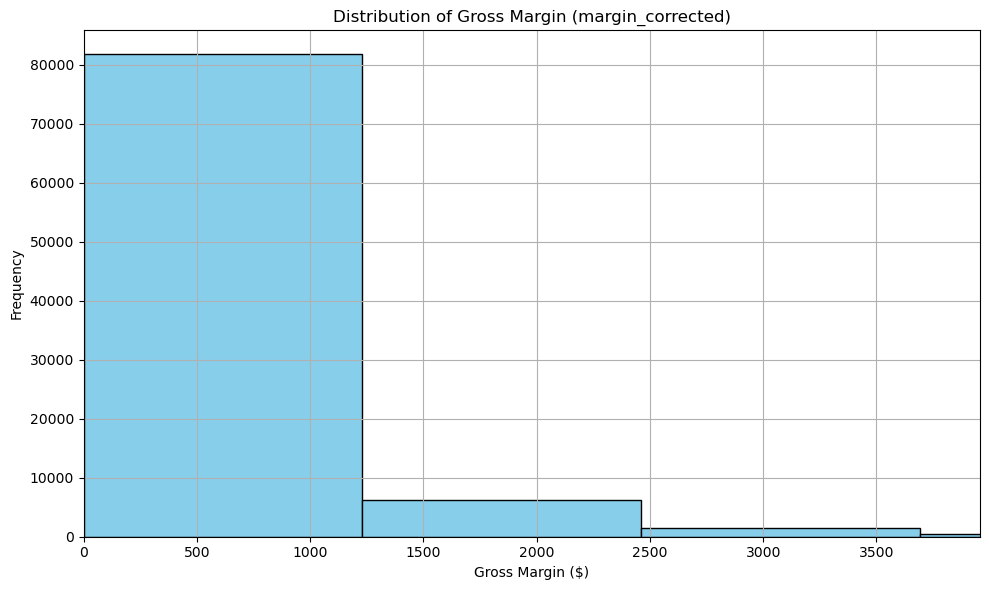

In [45]:


# Query to get margin_corrected values
query = """
    SELECT SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

# Load the data into a DataFrame
df = client.query(query).to_dataframe()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['margin_corrected'], bins=100, edgecolor='black', color='skyblue')
plt.title('Distribution of Gross Margin (margin_corrected)')
plt.xlabel('Gross Margin ($)')
plt.ylabel('Frequency')
plt.xlim(0, df['margin_corrected'].quantile(0.99))  # Zoom in to exclude extreme outliers
plt.grid(True)
plt.tight_layout()
plt.show()


count: 90088
mean: 272.24
median: 129.0
stddev: 388.51
min: 0
max: 6593
90th_percentile: 720.0
95th_percentile: 1007.0
99th_percentile: 1792.0
over_1_year: 25.09
over_2_years: 9.79


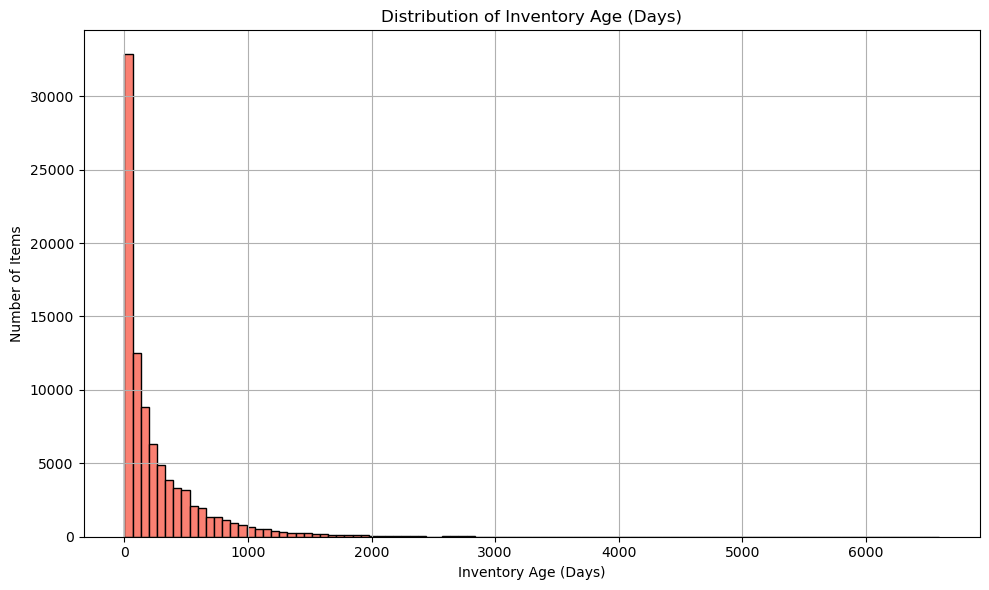

In [46]:
# Step 1: Load inventory age data
query = """
    SELECT SAFE_CAST(age_inventory_days AS INT64) AS age_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(age_inventory_days AS INT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Filter out negative ages (data issues)
df = df[df['age_days'] >= 0]

# Step 3: Calculate robust summary statistics
age_stats = {
    "count": len(df),
    "mean": df['age_days'].mean(),
    "median": df['age_days'].median(),
    "stddev": df['age_days'].std(),
    "min": df['age_days'].min(),
    "max": df['age_days'].max(),
    "90th_percentile": df['age_days'].quantile(0.90),
    "95th_percentile": df['age_days'].quantile(0.95),
    "99th_percentile": df['age_days'].quantile(0.99),
    "over_1_year": (df['age_days'] > 365).mean() * 100,
    "over_2_years": (df['age_days'] > 730).mean() * 100
}

# Step 4: Print the stats
for k, v in age_stats.items():
    print(f"{k}: {round(v, 2)}")

# Step 5: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age_days'], bins=100, color='salmon', edgecolor='black')
plt.title("Distribution of Inventory Age (Days)")
plt.xlabel("Inventory Age (Days)")
plt.ylabel("Number of Items")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Step 1: Query margin + key identifying fields
query = """
    SELECT 
        sku,
        vendor,
        style,
        category_name,
        SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected,
        SAFE_CAST(margin_percent AS FLOAT64) AS margin_percent,
        SAFE_CAST(cost AS FLOAT64) AS cost,
        SAFE_CAST(saleprice AS FLOAT64) AS saleprice,
        SAFE_CAST(age_inventory_days AS INT64) AS age_inventory_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

df = client.query(query).to_dataframe()

# Step 2: Filter to only valid margin rows
df = df[df['margin_corrected'].notna()]

# Step 3: Calculate 90th percentile
margin_cutoff = df['margin_corrected'].quantile(0.90)
print(f"90th percentile gross margin: ${round(margin_cutoff, 2)}")

# Step 4: Filter top 10% margin items
top_10_margin_df = df[df['margin_corrected'] > margin_cutoff]

# Optional: Sort and preview
top_10_margin_df = top_10_margin_df.sort_values(by='margin_corrected', ascending=False)
print(top_10_margin_df.head(10))

# Optional: Export to CSV
# top_10_margin_df.to_csv("top_10_percent_margin_inventory.csv", index=False)


90th percentile gross margin: $1197.5
                   sku vendor                style  \
8554     003-105-03399    JDC            CU900DEF2   
8493     001-105-03345    XLD                70492   
29705    001-155-04392    JDC        LIGHTNING 700   
8704     002-105-01881    JDC  EXCEPTIONAL3.52FMPT   
35385    001-170-01558    GAB       BG3968-65W45JJ   
8529   001-105-3000002   PREM                 AR19   
8586   001-105-3000013    JDC       E3SEM400TPS090   
42821    001-270-00474    ATL                12194   
40655    001-230-01709    ADG           ADG913645V   
38101    001-200-03108    JYE              RB38504   

                       category_name  margin_corrected  margin_percent  \
8554                     Live Bridal         123055.64          0.4102   
8493                     Live Bridal          65100.00          0.3426   
29705                  Diamond Studs          55027.00          0.4046   
8704                     Live Bridal          37568.00          0.3795 

Number of categories that make up 80% of gross sales: 11


,category_name,sale_total,cumulative_sales,cumulative_percent
0,Diamond Wedding Bands - Women's,5371265.21,5371265.21,13.938283
1,Diamond Engagement Rings,4914262.59,10285527.80,26.690656
2,Diamond Studs,3495649.96,13781177.76,35.761770
3,Watch,3388387.84,17169565.60,44.554541
4,Live Bridal,3353807.11,20523372.71,53.257576
5,Diamond Pendants,1910806.39,22434179.10,58.216065
6,Diamond Bracelets,1629648.72,24063827.82,62.444958
7,Diamond Fashion Rings - Women's,1424570.50,25488398.32,66.141679
8,Gold Chains,1405898.35,26894296.67,69.789945
9,Colored Stone Rings - Women's,1359167.02,28253463.69,73.316946


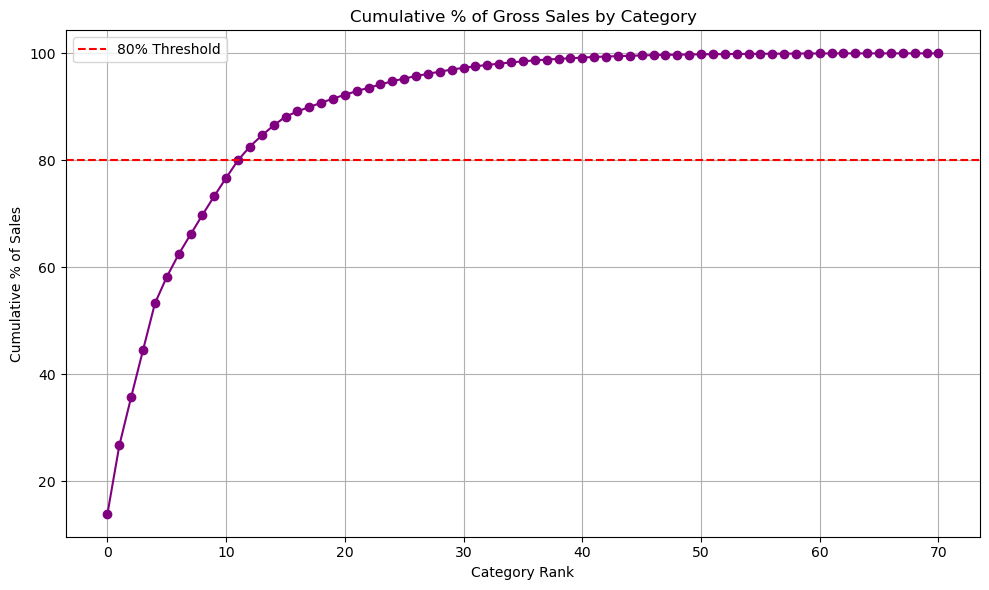

In [48]:
# Step 1: Query sales data by category
query = """
    SELECT 
        category_name,
        SAFE_CAST(sale_total AS FLOAT64) AS sale_total
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE category_name IS NOT NULL AND SAFE_CAST(sale_total AS FLOAT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Aggregate sales by category
category_sales = df.groupby('category_name', as_index=False)['sale_total'].sum()

# Step 3: Sort by total sales descending
category_sales = category_sales.sort_values(by='sale_total', ascending=False).reset_index(drop=True)

# Step 4: Calculate cumulative sales and % of total
category_sales['cumulative_sales'] = category_sales['sale_total'].cumsum()
total_sales = category_sales['sale_total'].sum()
category_sales['cumulative_percent'] = category_sales['cumulative_sales'] / total_sales * 100

# Step 5: Identify categories contributing to 80% of total sales
top_categories = category_sales[category_sales['cumulative_percent'] <= 80]

# Display result
print(f"Number of categories that make up 80% of gross sales: {len(top_categories)}")
display(category_sales.head(15))  # View top categories and their % contributions

# Optional: Plot the Pareto curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(category_sales['cumulative_percent'], marker='o', color='purple')
plt.axhline(80, color='red', linestyle='--', label='80% Threshold')
plt.title('Cumulative % of Gross Sales by Category')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative % of Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


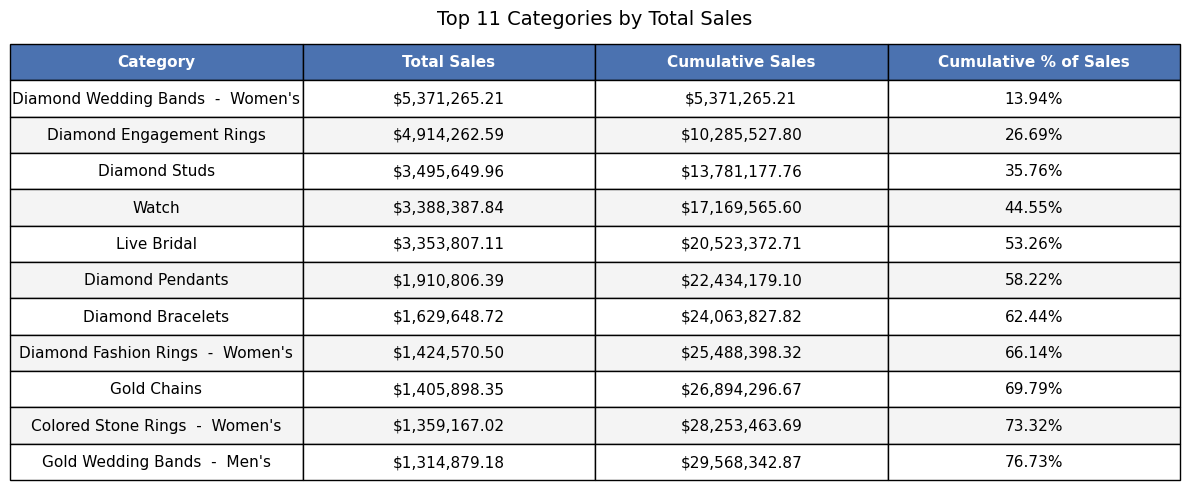

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have this DataFrame from earlier
top11 = category_sales.head(11).copy()

# Format numbers for display
top11['sale_total'] = top11['sale_total'].apply(lambda x: f"${x:,.2f}")
top11['cumulative_sales'] = top11['cumulative_sales'].apply(lambda x: f"${x:,.2f}")
top11['cumulative_percent'] = top11['cumulative_percent'].apply(lambda x: f"{x:.2f}%")

# Rename columns for display
top11.columns = ['Category', 'Total Sales', 'Cumulative Sales', 'Cumulative % of Sales']

# Plot table using matplotlib
fig, ax = plt.subplots(figsize=(12, 5))  # Adjust size as needed
ax.axis('off')
table = ax.table(
    cellText=top11.values,
    colLabels=top11.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)  # Adjust cell size (width, height)

# Optional: Style headers and cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4B72B0')  # header background
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')  # zebra striping


plt.title("Top 11 Categories by Total Sales", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("top_11_categories_table.png", dpi=300, bbox_inches='tight')
plt.show()


Trying a side-by-side comparison of Facebook Prophet model, and SARIMA model

In [54]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/15/9a/a8d35652e869011a3bae9e0888f4c62157bf9067c9be15535602c73039dd/prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/3c/1c/9e3fc8b8d4f2361b423e726732fcbb81f8817c7399a94d25296fc668586a/holidays-0.69-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd

In [58]:
# Use Live Bridal to forecast 1 category

query = """
SELECT 
  period AS ds,
  total_sales AS y
FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
WHERE category_name = 'Live Bridal'
ORDER BY ds
"""
df = client.query(query).to_dataframe()


18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing


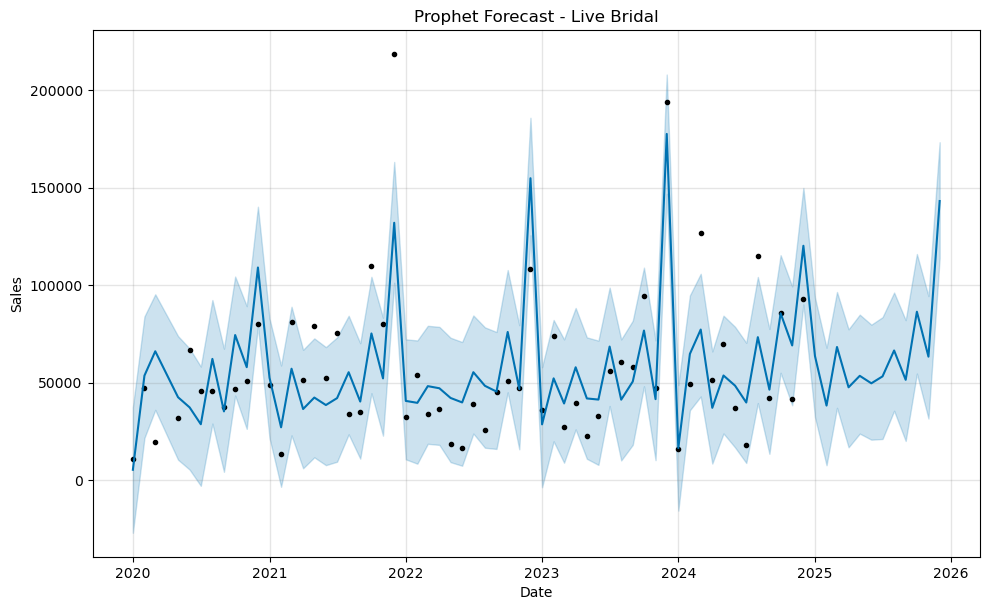

In [59]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df)

# Make future dataframe and forecast
future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast_prophet = model_prophet.predict(future)

# Plot Prophet forecast
fig1 = model_prophet.plot(forecast_prophet)
plt.title("Prophet Forecast - Live Bridal")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


/Users/juliehilley/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48885D+00    |proj g|=  4.50813D-02

At iterate    5    f=  9.45829D+00    |proj g|=  3.43030D-02

At iterate   10    f=  9.45458D+00    |proj g|=  1.40445D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.837D-06   9.455D+00
  F =   9.4545492115782377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


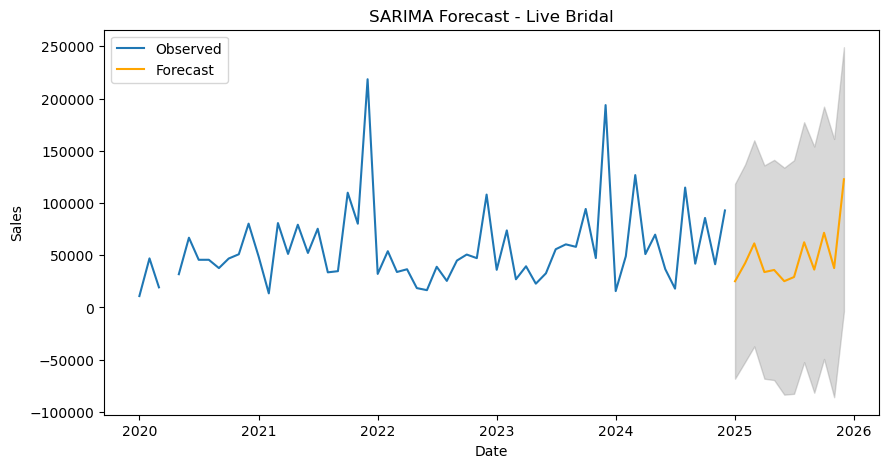

In [60]:
# Forecast with SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set datetime index and frequency
df_sarima = df.set_index('ds').asfreq('MS')

# Fit SARIMA model (basic config: (1,1,1)(1,1,1,12))
model_sarima = SARIMAX(df_sarima['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

# Forecast next 12 months
forecast_sarima = results_sarima.get_forecast(steps=12)
predicted_mean = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot SARIMA forecast
plt.figure(figsize=(10,5))
plt.plot(df_sarima['y'], label='Observed')
plt.plot(predicted_mean.index, predicted_mean, label='Forecast', color='orange')
plt.fill_between(predicted_mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast - Live Bridal")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()



Evaluate the forecasting performance of the above models using two common metrics:

MAPE (Mean Absolute Percentage Error)	Measures average absolute percent error. Easy to interpret — “X% off on average.”
RMSE (Root Mean Squared Error)	Penalizes large errors more than MAPE. Good when large spikes are important.

In [61]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np


In [64]:
# Evaluate Prophet
# Ensure both 'ds' columns are datetime64[ns]
df['ds'] = pd.to_datetime(df['ds'])
forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])

# Now merge safely
df_eval_prophet = pd.merge(df, forecast_prophet[['ds', 'yhat']], on='ds', how='left')

# Calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

mape_prophet = mean_absolute_percentage_error(df_eval_prophet['y'], df_eval_prophet['yhat']) * 100
rmse_prophet = np.sqrt(mean_squared_error(df_eval_prophet['y'], df_eval_prophet['yhat']))

print(f"📊 Prophet Performance (In-Sample):")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"RMSE: ${rmse_prophet:,.2f}")



📊 Prophet Performance (In-Sample):
MAPE: 41.36%
RMSE: $24,017.56


In [65]:
# Evaluate SARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Predict in-sample values from SARIMA
sarima_fitted = results_sarima.fittedvalues

# Align actuals with fitted values
df_eval_sarima = df_sarima.copy()
df_eval_sarima['yhat'] = sarima_fitted

# Drop missing values from early differencing periods
df_eval_sarima = df_eval_sarima.dropna()

# Calculate metrics
mape_sarima = mean_absolute_percentage_error(df_eval_sarima['y'], df_eval_sarima['yhat']) * 100
rmse_sarima = np.sqrt(mean_squared_error(df_eval_sarima['y'], df_eval_sarima['yhat']))

print(f"\n📊 SARIMA Performance (In-Sample):")
print(f"MAPE: {mape_sarima:.2f}%")
print(f"RMSE: ${rmse_sarima:,.2f}")



📊 SARIMA Performance (In-Sample):
MAPE: 72.52%
RMSE: $37,952.59
